# Repository Filtering Methods

The objective of this notebook is to filter repos belonging to the same ecosystem such that we can  best determine which projects (repos) share a similar goal. 

It contributes three filtering methods: 1) by contributor count 2) by project duration and 3) by activity. However, this notebook is meant to be a continuous work in progess as we gain more knowlegde about the relationships between contributors and projects in the ecosystem.


## Setup

In [1]:
#IMPORTS
import pandas as pd
import sqlalchemy as salc

import plotly.express as px
import json
import numpy as np
from IPython.display import Image
import math

In [2]:
#DATABASE ACCESS

with open("wasm_creds.json") as config_file:
    config = json.load(config_file)

database_connection_string = f"postgresql+psycopg2://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': f"-csearch_path={'augur_data'}"})

In [3]:
# SWITCHES

LOCAL_DATA = True 

## Contribution Event Stream

In [4]:
event_stream_query = salc.sql.text(
    f"""
        SET SCHEMA 'augur_data';
        SELECT 
            c.cntrb_id,
            c.event_id,
            c.created_at,
            c.cntrb_repo_id as repo_id,
            c.repo_git,
            c.repo_name,
            c.gh_repo_id,
            c.cntrb_category as event_type
        FROM
        contributor_repo c
    """)


if not LOCAL_DATA:
    with engine.connect() as conn:
        df_event_stream = pd.read_sql_query(event_stream_query, conn)
        
    with open("df_event_stream.parquet", "wb+") as f:
        df_event_stream.cntrb_id = df_event_stream.cntrb_id.astype(str)
        df_event_stream.to_parquet(f)
else:
    with open("df_event_stream.parquet", "rb+") as f:
        df_event_stream = pd.read_parquet(f)

In [5]:
# view head
df_event_stream.head()

,cntrb_id,event_id,created_at,repo_id,repo_git,repo_name,gh_repo_id,event_type
0,0100f4d9-0a00-0000-0000-000000000000,29206154815,2023-05-21 12:46:42,1331068,https://api.github.com/repos/mydeveloperday/sp...,mydeveloperday/spectral-sarif,643239814,PushEvent
1,01010bc1-fd00-0000-0000-000000000000,29266421350,2023-05-23 20:50:08,828122,https://api.github.com/repos/HazardyKnusperkek...,HazardyKnusperkeks/units,351321247,PushEvent
2,0100e8ca-1300-0000-0000-000000000000,32035370577,2023-09-22 14:59:22,50867574,https://api.github.com/repos/prometheus-operat...,prometheus-operator/prometheus-operator,68964263,ForkEvent
3,01010bc1-fd00-0000-0000-000000000000,29264457425,2023-05-23 19:13:06,828123,https://api.github.com/repos/llvm/llvm-project,llvm/llvm-project,75821432,IssueCommentEvent
4,0101b71a-0d00-0000-0000-000000000000,31189643965,2023-08-17 15:49:35,36340270,https://api.github.com/repos/Homebrew/homebrew...,Homebrew/homebrew-core,52855516,IssueCommentEvent


## Filter by number of contributors

First, we consider projects with more than 1 contributor, assuming that projects that only have 1 contributor do not enough event data for us to be able to draw similarities with between them and other projects. We can see from the following summary statistics that at least 25% of projects have only 1 contributor.

In [6]:
# count number of contributors for each project
cntrbCount = df_event_stream.groupby(['repo_name']).count()['cntrb_id'].sort_values().to_frame().reset_index()
cntrbCount = cntrbCount.rename(columns={'cntrb_id': 'cntrb_count'})

# view summary statistics
print(cntrbCount.describe())

         cntrb_count
count  324583.000000
mean       13.073698
std       135.632983
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max     49315.000000


Before we filter out projects that only have 1 contributor, we need to check our prior assumption that these projects lack event data. We do so by calculating the proportion of NaNs across event types for projects with single contributors.

In [7]:
# select repos with a single contributors
single_cntrb_repos = list(cntrbCount[cntrbCount['cntrb_count'] == 1]['repo_name'])

# filter for single contributor repos
singleCntrbEvents= df_event_stream[df_event_stream['repo_name'].isin(single_cntrb_repos)] 

# count contributions for each event type
singleCntrbEventsPivoted = pd.pivot_table(singleCntrbEvents, values='cntrb_id', index=['repo_name'],
                                          columns=['event_type'], aggfunc="count").reset_index()

# calculate proportion of NaNs across event types
print(singleCntrbEventsPivoted.iloc[:, 1:].isna().sum() / len(singleCntrbEventsPivoted))

event_type
CommitCommentEvent               0.975340
CreateEvent                      0.952818
DeleteEvent                      0.988279
ForkEvent                        0.943809
GollumEvent                      0.999701
IssueCommentEvent                0.899254
IssuesEvent                      0.969771
MemberEvent                      0.997403
PublicEvent                      0.990623
PullRequestEvent                 0.971992
PullRequestReviewCommentEvent    0.999985
PullRequestReviewEvent           0.994637
PushEvent                        0.765873
ReleaseEvent                     0.999211
WatchEvent                       0.551304
dtype: float64


Clearly, our prior assumption holds. A majority of projects with single contributors lack data across different event types. We proceed by filtering out such projects and checking the proportion of NaNs across all event times for multple contributor projects to observe the effect of doing so.

In [8]:
# select all repo names where there is more than 1 contributor
multiple_cntrb_repos = list(cntrbCount[cntrbCount['cntrb_count'] > 1]['repo_name'])

# filter for repos with multiple contributors
multCntrbEvents = df_event_stream[df_event_stream['repo_name'].isin(multiple_cntrb_repos)] 

# count contributions for each event type 
multCntrbEventsPivoted = pd.pivot_table(multCntrbEvents, values='cntrb_id', index=['repo_name'],
                                        columns=['event_type'], aggfunc="count").reset_index()

# calculate proportion of NaNs across event types
print(multCntrbEventsPivoted.iloc[:, 1:].isna().sum() / len(multCntrbEventsPivoted))

event_type
CommitCommentEvent               0.972790
CreateEvent                      0.610491
DeleteEvent                      0.823419
ForkEvent                        0.887836
GollumEvent                      0.995949
IssueCommentEvent                0.709689
IssuesEvent                      0.842744
MemberEvent                      0.985957
PublicEvent                      0.989152
PullRequestEvent                 0.694667
PullRequestReviewCommentEvent    0.933702
PullRequestReviewEvent           0.899926
PushEvent                        0.403165
ReleaseEvent                     0.964266
WatchEvent                       0.765134
dtype: float64


While the effect of filtering out single contributor projects is generally conservative, there is a dramatic difference between the availibility of data for `CreateEvent`, `IssueCommentEvent`, `PullRequestEvent`, and `PushEvent`.  We also can visualize the number contributions for each event type for both single and multiple contributor projects to get a better sense of the discrepancies in quantity and diversity of events. 

In [9]:
# count contributions for each event type for single and multiple contributor projects
singleCntrbEventsCounts = singleCntrbEvents['event_type'].value_counts()
multCntrbEventsCounts = multCntrbEvents['event_type'].value_counts()

# merge single and multiple contributor event types into a single DataFrame
cntrbEventCounts = pd.merge(
    singleCntrbEventsCounts,
    multCntrbEventsCounts, 
    left_index=True, 
    right_index=True
).rename(
    columns={'event_type_x': '1 Contributor', 
             'event_type_y': '> 1 Contributor'}
        )

fig_cec = px.bar(
        data_frame=cntrbEventCounts, 
        barmode='group', 
        labels={
                "variable": "Contributors",
                "value": "# Events",
                "index": "Kind of Event"  
        }
)
 
fig_cec.write_image("cntrbEventCounts.png")
fig_cec

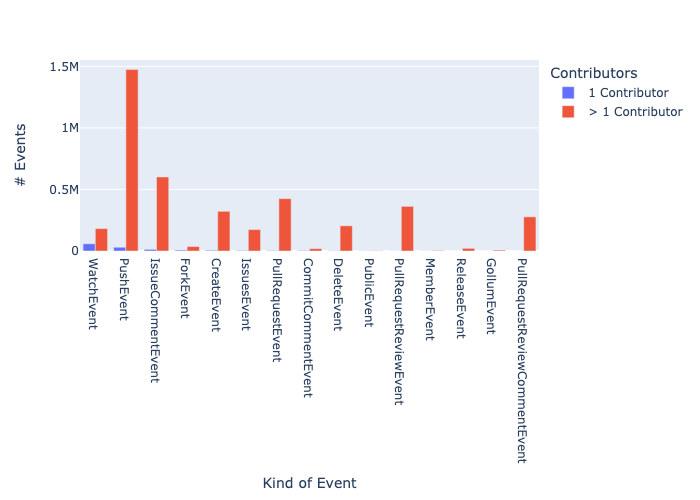

In [10]:
Image("cntrbEventCounts.png")

From the barplot, it is obvious that the multiple contributor repositories have more contributions across a more diverse set of event types which makes filtering for repos with more than 1 contributor a valid and useful strategy. For future work, the relationship between activity and the number of contributors to project should be further studied in order to determine a less arbitrary number for filtering out contributors. The following filtering methods will be applied to multiple contributor events only.

## Filter by project duration

Additionally, we want to consider projects that have existed for some time, under the assumption that the longer a project has existed, the more rich and diverse its set of contributor events are. This more features a project has, the easier it is to determine whether it share similarites with other projects in the ecosystem. More importantly, the longer a project has existed, the more the likely its contributors are to have participated in other projects.

We first calculate the lifetime for each project, in days, by subtracting its most recent event timestamp from its oldest timestamp.

In [11]:
# get latest and oldest event timestamps for each project
eventTimes = multCntrbEvents.groupby('repo_name').agg({'created_at': ['min', 'max']}).reset_index() 
eventTimes.columns = ['repo_name', 'min', 'max']

# get the duration of the project in terms of days
eventTimes['time_diff'] = (eventTimes['max'] - eventTimes['min']).dt.days

# view summary statistics of duration of projects
eventTimes['time_diff'].describe()

count    194047.000000
mean         33.620654
std          42.514535
min           0.000000
25%           0.000000
50%           9.000000
75%          56.000000
max         600.000000
Name: time_diff, dtype: float64

At least 50% of the projects in the ecosystem have existed for less than a day. Before we filter out such projects, we need to check the assumption we made earlier that projects that have existed for a shorter period of time have a less diverse set of contributor events. We do so by selecting all the projects that have existed for less than a day and viewing statistics about their event types. 

In [12]:
# get list of repos that have existed for less than a day
zero_days_repos = list(eventTimes[eventTimes['time_diff'] < 1]['repo_name'])

# only consider events from projects that have existed for less than a day
zeroDayEvents= multCntrbEvents[multCntrbEvents['repo_name'].isin(zero_days_repos)]

zeroDayEventsPivoted = pd.pivot_table(
        zeroDayEvents, 
        values='cntrb_id', 
        index=['repo_name'],
        columns=['event_type'], 
        aggfunc="count"
).reset_index()

# get proportion of projects that have no contributions for a given event type  
print(zeroDayEventsPivoted.iloc[:, 1:].isna().sum() / len(zeroDayEventsPivoted))

# get summary statistics for each project's event types
zeroDayEventsPivoted.describe()

event_type
CommitCommentEvent               0.967240
CreateEvent                      0.561389
DeleteEvent                      0.872316
ForkEvent                        0.924684
GollumEvent                      0.999113
IssueCommentEvent                0.832287
IssuesEvent                      0.944662
MemberEvent                      0.992361
PublicEvent                      0.990351
PullRequestEvent                 0.702446
PullRequestReviewCommentEvent    0.985312
PullRequestReviewEvent           0.968822
PushEvent                        0.445866
ReleaseEvent                     0.977451
WatchEvent                       0.929693
dtype: float64


event_type,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PullRequestReviewEvent,PushEvent,ReleaseEvent,WatchEvent
count,2217.000000,29683.000000,8641.000000,5097.000000,60.000000,11350.000000,3745.000000,517.000000,653.000000,20137.000000,994.000000,2110.000000,37501.000000,1526.000000,4758.000000
mean,2.736581,1.824816,1.752691,1.036492,2.500000,2.188194,1.573031,1.299807,1.006126,1.661171,2.828974,2.060190,2.553745,1.605505,1.402270
std,2.810354,3.433001,5.263700,0.264758,2.281094,2.114029,2.042960,1.156822,0.078086,1.852223,3.761110,2.243726,3.527307,7.634285,0.769676
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
75%,3.000000,2.000000,1.000000,1.000000,3.000000,2.000000,2.000000,1.000000,1.000000,2.000000,3.000000,2.000000,3.000000,1.000000,2.000000
max,78.000000,299.000000,277.000000,10.000000,12.000000,42.000000,58.000000,24.000000,2.000000,108.000000,41.000000,34.000000,212.000000,296.000000,13.000000


Clearly, our assumption holds. The majority of projects that have existed for less than a day have no contributor events. Furthermore, the mean and median of each event type accross these projects is less than 3 which is not helpful to our future analyses. We can now proceed to filter them out of the initial set of events for multiple contributor repos.

In [13]:
# get list of repos that have existed for a day or more
nonzero_days_repos = list(eventTimes[eventTimes['time_diff'] >= 1]['repo_name'])

# only consider events from projects that have existed for at least a day
nonzeroDayEvents = multCntrbEvents[multCntrbEvents['repo_name'].isin(nonzero_days_repos)]

nonzeroDayEventsPivoted = pd.pivot_table(nonzeroDayEvents, values='cntrb_id', index=['repo_name'],
                                        columns=['event_type'], aggfunc="count").reset_index()
# get proportion of projects that have no contributions for a given event type  
print(nonzeroDayEventsPivoted.iloc[:, 1:].isna().sum() / len(nonzeroDayEventsPivoted))

# get summary statistics for each project's event types
nonzeroDayEventsPivoted.describe()

event_type
CommitCommentEvent               0.975762
CreateEvent                      0.636787
DeleteEvent                      0.797234
ForkEvent                        0.868104
GollumEvent                      0.994255
IssueCommentEvent                0.644035
IssuesEvent                      0.788165
MemberEvent                      0.982528
PublicEvent                      0.988510
PullRequestEvent                 0.690501
PullRequestReviewCommentEvent    0.906063
PullRequestReviewEvent           0.863031
PushEvent                        0.380298
ReleaseEvent                     0.957206
WatchEvent                       0.677009
dtype: float64


event_type,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PullRequestReviewEvent,PushEvent,ReleaseEvent,WatchEvent
count,3063.000000,45900.000000,25624.000000,16668.000000,726.000000,44984.000000,26770.000000,2208.000000,1452.000000,39112.000000,11871.000000,17309.000000,78313.000000,5408.000000,40817.000000
mean,4.197845,5.841351,7.392640,1.850252,9.690083,12.816224,6.273814,1.529891,1.014463,10.017463,23.138405,20.692588,17.593924,3.532914,4.297352
std,11.633278,52.844454,94.199591,5.600788,19.899169,102.575321,39.757488,2.005433,0.130461,39.302049,93.397785,94.419121,77.837383,9.043042,14.776628
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,1.000000,3.000000,3.000000,2.000000,1.000000,1.000000,3.000000,5.000000,4.000000,5.000000,2.000000,2.000000
75%,4.000000,5.000000,6.000000,2.000000,8.000000,8.000000,4.000000,2.000000,1.000000,7.000000,15.000000,12.000000,14.000000,3.000000,3.000000
max,322.000000,10484.000000,14505.000000,498.000000,229.000000,14250.000000,5561.000000,59.000000,3.000000,3405.000000,5643.000000,6573.000000,12759.000000,336.000000,1590.000000


In [14]:
# count contributions for each event type for projects that have existed for less than a day and a day and more
zeroDayEventCounts = zeroDayEvents.event_type.value_counts()
nonzeroDayEventCounts = nonzeroDayEvents.event_type.value_counts()

# merge zero day and non-zero day event counts
dayEventCounts = pd.merge(
    zeroDayEventCounts, 
    nonzeroDayEventCounts, 
    left_index=True, 
    right_index=True
).rename(
    columns={
        'event_type_x': '< 1 day', 
        'event_type_y': '1+ day'
    }
)

fig_dec = px.bar(
    data_frame=dayEventCounts,
    barmode="group",
    labels={        
                     "variable": "Project Duration",
                     "value": "# Events",
                     "index": "Kind of Event"
                 },
)

fig_dec.write_image("dayEventCounts.png")
fig_dec

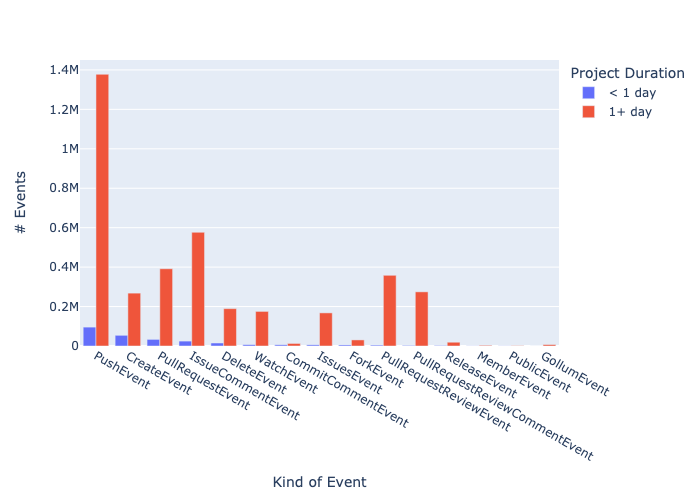

In [15]:
Image("dayEventCounts.png")

Granted, even after filtering, the majority of projects that have existed for more than a day still have no contributor events given the conservative criteria for filtering by project duration. However, the lack of event data is not as severe and there is clearly more diversity in the set of events as evidenced by the increase in mean and median of each event type across these projects. We can also come to a similar conclustion by observing the barplot where there seems to be a significant difference in the number and range of event data between projects that have existed for less than a day and their counterparts.

## Filter by event types

Based on the previous two analyses and even after filtering out projects based on contributors and duration, a majority still lack certain contibutor events that characterize "active" projects. We naively define "active" projects as those that have data for at least the following events: **'CreateEvent', 'ForkEvent', 'IssuesEvent', 'PullRequestEvent', 'PullRequestReviewEvent'**

In [16]:
# get list of repos that have data and don't have data for events of interest
active_projects_repos = list(nonzeroDayEventsPivoted[nonzeroDayEventsPivoted[['CreateEvent', 'ForkEvent', 'IssuesEvent', 'PullRequestEvent', 'PullRequestReviewEvent']].notnull().all(1)].repo_name)
nonactive_projects_repos = list(nonzeroDayEventsPivoted[nonzeroDayEventsPivoted[['CreateEvent', 'ForkEvent', 'IssuesEvent', 'PullRequestEvent', 'PullRequestReviewEvent']].isnull().all(1)].repo_name)

# filter for repos
activeEvents = nonzeroDayEvents[nonzeroDayEvents['repo_name'].isin(active_projects_repos)]
nonactiveEvents = nonzeroDayEvents[nonzeroDayEvents['repo_name'].isin(nonactive_projects_repos)]

# count event types for active and non-active projects
activeEventsCounts = activeEvents['event_type'].value_counts().reset_index()
nonactiveEventsCounts = nonactiveEvents['event_type'].value_counts().reset_index()

# merge active and non-active project event counts
eventsCounts = pd.merge(
    activeEventsCounts, 
    nonactiveEventsCounts, 
    how='left',
    left_on='index',
    right_on='index'
).set_index('index').rename(
    columns={
        'event_type_x':'Yes', 
        'event_type_y': 'No'
    }
)

fig_ec = px.bar(
    data_frame=eventsCounts,
    barmode="group", 
    labels={
        "variable": "Is Active?",
        "value": "# Events",
        "index": "Kind of Event"
    }   
)

fig_ec.write_image("eventCounts.png")
fig_ec

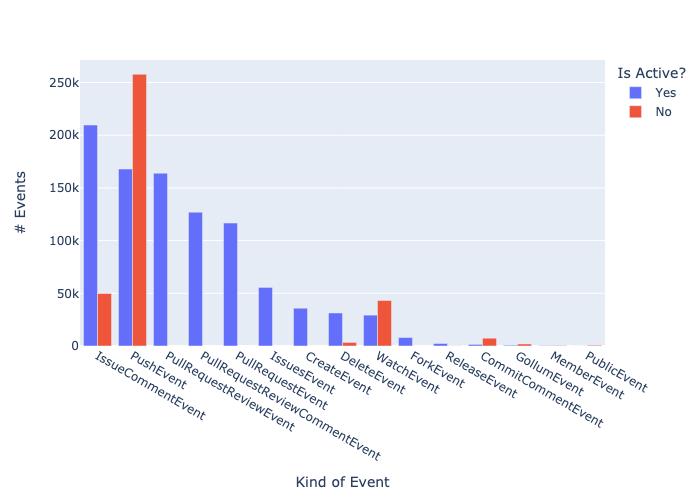

In [17]:
Image("eventCounts.png")

## Conclusion

We can view the cumulative effect of our filtering methods by comparing the length and number of unique repositories of our original DataFrame and the resulting the DataFrame.

In [18]:
print(f"Diff in size: {len(df_event_stream)} compared to {len(activeEvents)}")

Diff in size: 4243500 compared to 949957


In [19]:
print(f"Diff in number of repos: {df_event_stream.repo_name.nunique()} compared to {activeEvents.repo_name.nunique()}")

Diff in number of repos: 324583 compared to 2073


The initial set of events represented the activity of the population of all Github users. 

By filtering out projects with single contributors, projects that have existed for less than a day, and "non-active" projects, the length of the DataFrame changed from 4.2 million events to 950K events. Additionally, the number of unique GitHub repositories changed from 324583 to 2073.  

This is a first attempt at applying filtering methods and for future research, we aim to use less arbitrary numbers such as a single contributor and less than a day for filtering criteria as we gain more domain knowledge of the ecosystem of projects.